# BBM 409 - Programming Assignment 3
### Group 36: Aydan Çelik (2210356103)

### 1. Visualization of the Data

In [1]:
import pandas as pd
df = pd.read_csv("amazon_reviews.csv")

df.head()

,Title,Content,Star
0,Didn't work,No change in nails at all.,1.0
1,Worst nail product I have ever used.,Garbage! Do not waste your $$$. My nails were ...,1.0
2,Just didn't work,Nails are still brittle,1.0
3,Scum,Didn’t do any improvement at all.,1.0
4,Okay for cuticles,"Helped cuticles, didn't do much for my nails. ...",1.0


In [2]:
!pip install wordcloud

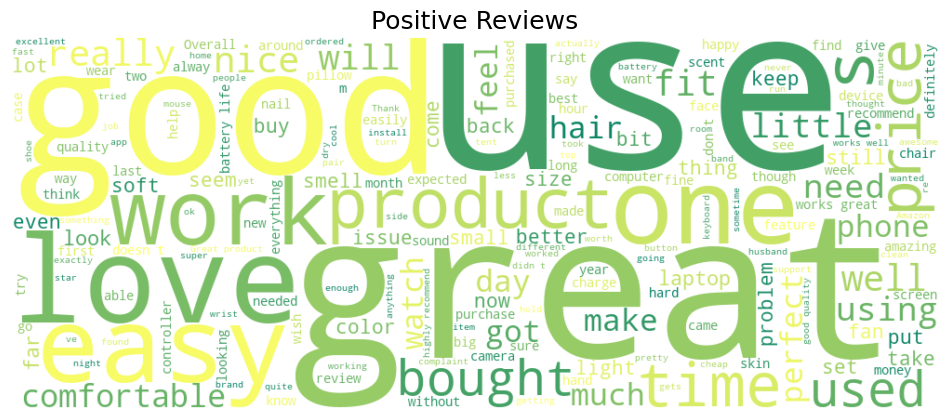

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# filtering positive review contents
positive = " ".join(df[df["Star"].isin([4, 5])]["Content"].astype(str))

positive_wc = WordCloud(width=1000, height=400, background_color="white", colormap="summer").generate(positive)
plt.figure(figsize=(12, 5))
plt.imshow(positive_wc, interpolation="bilinear")
plt.title("Positive Reviews", fontsize=18)
plt.axis("off")
plt.show()

The word cloud for positive reviews highlights terms like "great", "easy", "use", "love", and "good", which appear frequently. These words reflect common patterns in satisfied customer experiences, emphasizing ease of use, product quality, and emotional satisfaction. Overall, the visual confirms that positive reviews often focus on usefulness, comfort, and value. This supports the effectiveness of these words as strong features in a sentiment classification task.

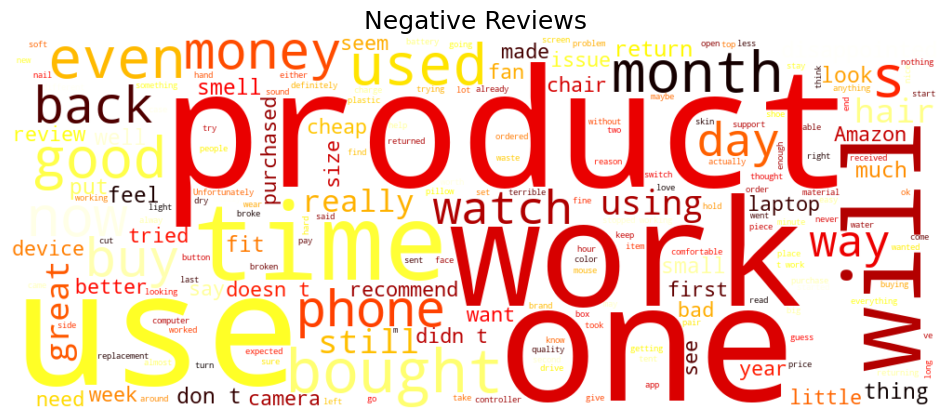

In [4]:
# filtering negative review contents
negative = " ".join(df[df["Star"].isin([1, 2])]["Content"].astype(str))

negative_wc = WordCloud(width=1000, height=400, background_color="white", colormap="hot").generate(negative)

plt.figure(figsize=(12, 5))
plt.imshow(negative_wc, interpolation="bilinear")
plt.title("Negative Reviews", fontsize=18, color="black")
plt.axis("off")
plt.gca().set_facecolor("black")
plt.show()

In the negative review word cloud, terms such as "disappointed", "return", "money", "broke", and "smell" stand out, indicating dissatisfaction and issues with product quality. Frequent use of words like "didn", "don’t", "stopped", and "problem" reveals frustration and negative experiences. The repetition of "month", "back", and "used" suggests problems araising after some periods. Unlike positive reviews, the language here is more critical and complaint-driven. This highlights the importance of capturing these terms when training a classifier to detect negative sentiment.

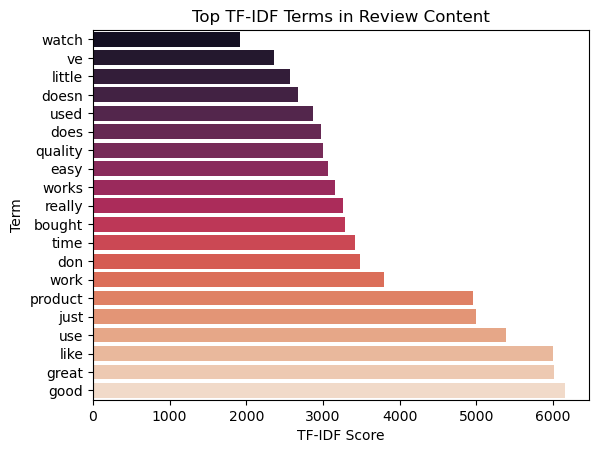

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

tfidf = TfidfVectorizer(max_features=20, stop_words="english")
X = tfidf.fit_transform(df["Content"].astype(str))
features = tfidf.get_feature_names_out()
scores = X.sum(axis=0).A1

tfidf_df = pd.DataFrame({"term": features, "score": scores})
tfidf_df.sort_values("score", ascending=True, inplace=True)

sns.barplot(data=tfidf_df, x="score", y="term", palette="rocket")
plt.title("Top TF-IDF Terms in Review Content")
plt.xlabel("TF-IDF Score")
plt.ylabel("Term")
plt.show()

TF-IDF is a method used to determine how important a word is in a document. It reduces the impact of very common words and highlights more meaningful ones. In the graph, words like "great", "good", and "like" have high TF-IDF scores, which suggests that they are more helpful in identifying the score of a review.

###### Creating Train and Test Sets

In [6]:
from sklearn.model_selection import train_test_split

# drop 3 star reviews
df = df[df["Star"] != 3]

# map star to label (negative/positive)
def label_sentiment(star):
    return 1 if star in [4, 5] else 0

df["Label"] = df["Star"].apply(label_sentiment)

# assign weights based on star
def assign_weight(star):
    if star == 1 or star == 5:
        return 2.0
    elif star == 2 or star == 4:
        return 1.0

df["Weight"] = df["Star"].apply(assign_weight)

# split into train/test (stratify based on label)
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Label"])

By stratifying based on the binary label (positive/negative), original balance of the classes is preserved. This prevents skewed distributions that could lead to biased model evaluation or poor generalization performance.

To simplify the problem into a binary classification, 3-star (neutral) reviews were dismissed. Including neutral reviews would have required a more complex model and potentially introduced ambiguity into the training labels. By removing them, a sharper decision boundary will be acheived which will lead to a better generalization.

Since 1 and 5 star reviews express stronger sentiment compared to 2 and 4 star reviews, weighting is used during feature extraction. Reviews with extreme ratings were given higher weights (2.0) compared to less extreme ratings (1.0), ensuring that strongly opinionated reviews have a greater impact on the classifier.

### 2. Implementation of the Bag of Words Method

In [7]:
import re

def tokenize(text):
    """
    Tokenizes text:
    - Lowercases
    - Keeps punctuation as separate tokens (.,!?)
    - Removes other special characters
    """
    text = text.lower()
    
    # inserting spaces around .,!? so they are treated as words
    text = re.sub(r"([.,!?])", r" \1 ", text)
    
    # remove other symbols
    text = re.sub(r"[^a-z0-9\s.,!?]", "", text)  
    
    tokens = text.split()
    return tokens

In [8]:
def combine_title_content(title, content, title_weight=1, content_weight=1, n=1):
    """
    Combines title and content with weighting, and generates n-grams (n=1 for unigram, n=2 for bigram etc.)
    """
    title_tokens = tokenize(str(title))
    content_tokens = tokenize(str(content))
    
    # apply weights by repeating tokens
    weighted_tokens = title_tokens * title_weight + content_tokens * content_weight

    # create n-grams
    if n == 1:
        return weighted_tokens
    
    else:
        ngrams = []
        for i in range(len(weighted_tokens) - n + 1):
            ngram = " ".join(weighted_tokens[i:i+n])
            ngrams.append(ngram)
        return ngrams


My approach was to combine the title and content of each review into a single input. Treating the title and content separately coould overcomplicate the model without significant benefit. It would require building two distinct Bag of Words representations and a strategy to combine their outputs during classification. Also, titles are much shorter than contents; training a separate model on titles alone could lead to a less stable representation of the data. For these reasons, combining title and content into a single, weighted input was preferred as a more effective approach.

By combining them, the model benefits from both the emotional intensity captured in the title and the further explanation found in the content. To balance their contributions, different weights can be assigned to the title and content, allowing model to generalize better by capturing both the emotional cues from the title and the detailed explanations from the content.

In [9]:
from collections import defaultdict

def build_bow(train_df, title_weight=1, content_weight=1, n=1):
    """
    Builds Bag of Words dictionaries for positive and negative reviews.
    Supports unigrams (n=1), bigrams (n=2), trigrams (n=3) etc.
    """
    
    positive_words = defaultdict(float)
    negative_words = defaultdict(float)
    
    for _, row in train_df.iterrows():
        title = row["Title"]
        content = row["Content"]
        label = row["Label"]
        review_weight = row["Weight"]

        tokens = combine_title_content(title, content, title_weight, content_weight, n)

        for token in tokens:
            # positive
            if label == 1:  
                positive_words[token] += review_weight
                
            # negative    
            else:          
                negative_words[token] += review_weight

    # to apply laplace smoothing later            
    total_positive_words = sum(positive_words.values())
    total_negative_words = sum(negative_words.values())

    return positive_words, negative_words, total_positive_words, total_negative_words


Stopword removal was not applied during the initial Bag of Words construction to maintain a simpler and more consistent implementation, as allowed by the assignment instructions.

The Bag of Words model was extended to handle n-grams by creating consecutive word combinations after tokenization. This allowed the model to capture more context in the input text.

### 3. Implementation of Naïve Bayes Algorithm

In [10]:
import math

def predict(title, content, positive_words, negative_words, total_positive_words, total_negative_words, 
            vocab_size, title_weight=1, content_weight=1, n=1, alpha=1.0):
    
    """
    Predicts the label (0=negative, 1=positive) for a given review.
    Uses log-probabilities and Laplace smoothing (alpha).
    """

    tokens = combine_title_content(title, content, title_weight, content_weight, n)

    # log probabilities
    log_pos = 0
    log_neg = 0

    for token in tokens:
        # get token counts
        pos_token_count = positive_words.get(token, 0)
        neg_token_count = negative_words.get(token, 0)

        # apply laplace smoothing
        given_pos = (pos_token_count + alpha) / (total_positive_words + alpha * vocab_size)
        given_neg = (neg_token_count + alpha) / (total_negative_words + alpha * vocab_size)

        # adding log probabilities
        log_pos += math.log(given_pos)
        log_neg += math.log(given_neg)

    # decision boundry
    if log_pos > log_neg:
        return 1  # positive
    else:
        return 0  # negative


The prediction function applies Naïve Bayes classification using a logarithmic probability space to prevent numerical underflow. After tokenizing and combining the title and content with appropriate weights and n-gram settings, the function retrieves token counts from the pre-built Bag of Words dictionaries. 

Laplace smoothing is applied to handle unseen tokens, ensuring that no probability becomes zero. The parameter alpha represents the smoothing factor used during probability estimation, and it is set to 1.0 to implement classical Laplace smoothing.

The final classification is based on comparing the log-probabilities for the positive and negative classes, returning the class with the higher total.

### 4. Evaluation Metrics

In [11]:
def evaluate_model(test_df, positive_words, negative_words, total_positive_words, total_negative_words, 
                   vocab_size, title_weight=1, content_weight=1, n=1, alpha=1.0):

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for _, row in test_df.iterrows():
        title = row["Title"]
        content = row["Content"]
        true_label = row["Label"]

        pred_label = predict(title, content, positive_words, negative_words, total_positive_words, total_negative_words, 
            vocab_size, title_weight, content_weight, n, alpha)

        if pred_label == 1 and true_label == 1:
            TP += 1
        elif pred_label == 0 and true_label == 0:
            TN += 1
        elif pred_label == 1 and true_label == 0:
            FP += 1
        elif pred_label == 0 and true_label == 1:
            FN += 1

    # Calculations
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    """
    print(f"Title Weight:     {title_weight}")
    print(f"Content Weight:   {content_weight}")
    print(f"N-gram Size:  {n}")
    print(f"Alpha:    {alpha}")
    print(f"Vocabulary Size:  {vocab_size}")
    print("-----------------------")
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    """

    return accuracy, precision, recall, f1


This function evaluates the trained model by manually calculating standard classification metrics without using external libraries. For each review in the test set, it predicts the label using the predict function and compares it to the true label. Using these counts, the function computes accuracy, precision, recall, and F1-score according to standard definitions.

### 5. Experiments

In [12]:
def experiment(train_df, test_df, title_weight=1, content_weight=1, n=1, alpha=1.0):
    """
    Builds BoW, trains, evaluates the model for given hyperparameters in one call.
    """

    # build bow
    positive_words, negative_words, total_positive_words, total_negative_words = build_bow(train_df, title_weight, 
                                                                                           content_weight, n=n)

    # build vocabulary
    vocab = set(list(positive_words.keys()) + list(negative_words.keys()))
    vocab_size = len(vocab)

    # evaluate
    accuracy, precision, recall, f1 = evaluate_model(test_df, positive_words, negative_words, 
                                                     total_positive_words, total_negative_words,
                                                     vocab_size, title_weight, content_weight, n, alpha)

    return {
        "Title Weight": title_weight,
        "Content Weight": content_weight,
        "N-gram": n,
        "Alpha": alpha,
        "Vocab Size": vocab_size,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    }


In [13]:
experiments = []

# unigrams, bigrams, trigrams
for n in [1, 2, 3]: 
    
    # alternate content weight between 1 and 2
    for content_weight in [1, 2]:
        
        # different title weight
        for title_weight in [1, 2, 3]:  
            
            # different smoothing
            for alpha in [1.0, 0.5]:
                
                experiments.append({
                    "title_weight": title_weight,
                    "content_weight": content_weight,
                    "n": n,
                    "alpha": alpha
                })  
            

results = []
i = 0

for exp in experiments:
    result = experiment(train_df, test_df, 
                        title_weight=exp["title_weight"], 
                        content_weight=exp["content_weight"], 
                        n=exp["n"],
                        alpha=exp["alpha"])
    results.append(result)
    i+=1



=== Model # 0 ===




=== Model # 1 ===




=== Model # 2 ===




=== Model # 3 ===




=== Model # 4 ===




=== Model # 5 ===




=== Model # 6 ===




=== Model # 7 ===




=== Model # 8 ===




=== Model # 9 ===




=== Model # 10 ===




=== Model # 11 ===




=== Model # 12 ===




=== Model # 13 ===




=== Model # 14 ===




=== Model # 15 ===




=== Model # 16 ===




=== Model # 17 ===




=== Model # 18 ===




=== Model # 19 ===




=== Model # 20 ===




=== Model # 21 ===




=== Model # 22 ===




=== Model # 23 ===




=== Model # 24 ===




=== Model # 25 ===




=== Model # 26 ===




=== Model # 27 ===




=== Model # 28 ===




=== Model # 29 ===




=== Model # 30 ===




=== Model # 31 ===




=== Model # 32 ===




=== Model # 33 ===




=== Model # 34 ===




=== Model # 35 ===





In accordance with the assignment requirements, multiple experiments were conducted by varying n-gram sizes (unigram, bigram, trigram), title-to-content weighting ratios, and smoothing factors (alpha). A total of 36 model configurations were evaluated based on accuracy, precision, recall, and F1-score to determine the best-performing settings.

### 6. Results and Analysis

In [14]:
# creating a dataframe to show results
results_df = pd.DataFrame(results)
results_df

,Title Weight,Content Weight,N-gram,Alpha,Vocab Size,Accuracy,Precision,Recall,F1-Score
0,1,1,1,1.0,29241,0.870086,0.864741,0.877414,0.871031
1,1,1,1,0.5,29241,0.868017,0.861351,0.877241,0.869224
2,2,1,1,1.0,29241,0.877931,0.877021,0.879138,0.878078
3,2,1,1,0.5,29241,0.877328,0.874936,0.880517,0.877718
4,3,1,1,1.0,29241,0.880948,0.882863,0.878448,0.880650
5,3,1,1,0.5,29241,0.880776,0.881763,0.879483,0.880621
6,1,2,1,1.0,29241,0.855862,0.848296,0.866724,0.857411
7,1,2,1,0.5,29241,0.854914,0.847543,0.865517,0.856436
8,2,2,1,1.0,29241,0.868017,0.861351,0.877241,0.869224
9,2,2,1,0.5,29241,0.868190,0.861031,0.878103,0.869484


#### Impact of N-gram Size

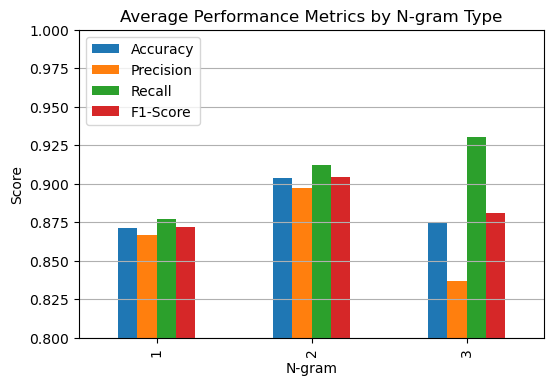

In [15]:
grouped = results_df.groupby("N-gram")[["Accuracy", "Precision", "Recall", "F1-Score"]].mean()

grouped.plot(kind="bar", figsize=(6,4))

plt.title("Average Performance Metrics by N-gram Type")
plt.xlabel("N-gram")
plt.ylabel("Score")
plt.ylim(0.8, 1.0)
plt.legend(loc="upper left")
plt.grid(axis="y")
plt.show()

Unigram models offer simplicity and computational efficiency, but their inability to capture contextual phrases limits their effectiveness compared to bigrams and trigrams in sentiment classification tasks. For instance, unigrams would treat "not" and "good" independently, missing the critical phrase "not good" that expresses negative sentiment. 

Moving from unigrams (n=1) to bigrams (n=2) significantly improves performance across all metrics (Accuracy, Precision, Recall, F1-Score). Best performing models were found at bigrams.

While bigram models generally achieved the best overall balance of performance, trigram models demonstrated higher recall values. This indicates that trigrams were more effective at identifying positive and negative examples, possibly due to capturing more specific phrases in the review texts. However, this caused a drop in precision, probably because trigrams were more sparse (exact three-word combinations occur less frequently) and made the model overfit the training data.

#### Vocabulary Size Growth and Its Effects
Vocabulary size is the number of unique features used by the model. It grows rapidly with higher n-gram levels, since bigrams and trigrams create many more word combinations. A larger vocabulary can improve performance by capturing more patterns, but it also increases model complexity and the risk of overfitting. In these results, vocabulary size rose from about 29,000 in unigrams to over 1.1 million in trigrams, highlighting the trade-off between feature richness and generalization.

#### Impact of Title and Content Weights

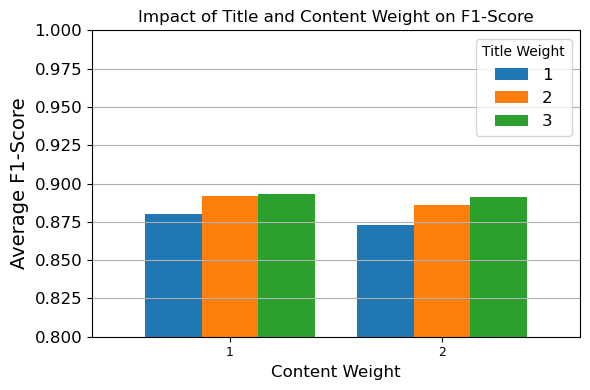

In [16]:
results_df["Title:Content"] = results_df["Title Weight"].astype(str) + ":" + results_df["Content Weight"].astype(str)
grouped = results_df.groupby(["Content Weight", "Title Weight"])["F1-Score"].mean().unstack()

grouped.plot(kind="bar", figsize=(6,4), width=0.8)

plt.title("Impact of Title and Content Weight on F1-Score", fontsize=12)
plt.xlabel("Content Weight", fontsize=12)
plt.ylabel("Average F1-Score", fontsize=14)
plt.ylim(0.8, 1.0)
plt.legend(title="Title Weight", fontsize=12, title_fontsize=10)
plt.grid(axis="y")
plt.xticks(rotation=0, fontsize=9)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

This bar plot shows how the Title Weight and Content Weight settings impact the average F1-Score of the Naive Bayes classifier.
The F1-Score rises noticeably from Title Weight 1 to 2 and 3. This suggests that giving additional importance to the title can enhance classification performance.

When comparing different Content Weight settings, models with Content Weight = 1 consistently achieve higher F1-Scores than those with Content Weight = 2, indicating that giving excessive emphasis to the content is not optimal.

These results indicate that, in this dataset, title carries more predictive value than the content, and assigning greater weight to it results in a better classification.

#### Impact of Alpha

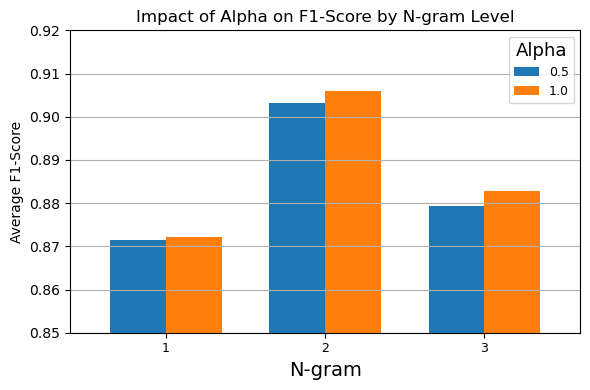

In [17]:
alpha_scores = results_df[results_df["Alpha"].isin([0.5, 1.0])]
grouped = alpha_scores.groupby(["N-gram", "Alpha"])["F1-Score"].mean().unstack()

grouped.plot(kind="bar", figsize=(6,4), width=0.7)

plt.title("Impact of Alpha on F1-Score by N-gram Level", fontsize=12)
plt.xlabel("N-gram", fontsize=14)
plt.ylabel("Average F1-Score", fontsize=10)
plt.ylim(0.85, 0.92)
plt.xticks(rotation=0, fontsize=9)
plt.legend(title="Alpha", fontsize=9, title_fontsize=13)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


The bar chart shows how different alpha values (0.5 and 1.0) affect the average F1-Score for unigram, bigram, and trigram models. Overall, alpha = 1.0 performs slightly better than alpha = 0.5 across all n-gram levels, with the biggest difference seen in the bigram and trigram cases. This suggests that using more smoothing helps the model generalize better, especially when dealing with larger and sparser feature spaces like bigrams and trigrams. For unigrams, the difference is very small. Based on these results, using alpha = 1.0 seems to be the best choice for this task.

#### Conclusion
The results show that bigram models perform best overall, offering a good balance between context and generalization. Trigrams improved recall but led to lower precision due to feature sparsity and overfitting. Models performed better when more weight was given to the title rather than the content, suggesting that the title carries more predictive value. Additionally, alpha = 1.0 provided better results than alpha = 0.5, especially for larger n-grams. Overall, careful tuning of n-gram size, feature weighting, and smoothing is key to improving Naive Bayes classification performance.

In [18]:
best_row = results_df.loc[results_df["F1-Score"].idxmax()]
print(best_row)

Title Weight             2
Content Weight           1
N-gram                   2
Alpha                  1.0
Vocab Size          393868
Accuracy          0.911552
Precision         0.909997
Recall            0.913448
F1-Score          0.911719
Title:Content          2:1
Name: 14, dtype: object


### 7. Bonus Part

### NLTK

In [19]:
!pip install nltk

import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
import string

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aydan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aydan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stop_words = set(stopwords.words("english"))
punctuations = set(string.punctuation)

# Tokenization
def preprocess(text, n=1):
    tokens = word_tokenize(text.lower())  
    
    tokens = [t for t in tokens if t not in stop_words and t not in punctuations and t.isalpha()]
    if n == 1:
        return tokens
    else:
        return [' '.join(gram) for gram in ngrams(tokens, n)]
    

##### From Previous BoW Implementation (Minor Changes)

In [21]:
def combine_title_content_nltk(title, content, title_weight=1, content_weight=1, n=1):
    "Replaced tokenize() with preprocess()"
    title_tokens = preprocess(str(title), n)
    content_tokens = preprocess(str(content), n)
    
    weighted_tokens = title_tokens * title_weight + content_tokens * content_weight
    return weighted_tokens


def build_bow_nltk(train_df, title_weight=1, content_weight=1, n=1, min_freq=5):
    """
    Changed from combine_title_content() to combine_title_content_nltk()
    Filtering rare (low-frequency) tokens to control the vocabulary size. 
    """
    
    positive_words = defaultdict(float)
    negative_words = defaultdict(float)

    for _, row in train_df.iterrows():
        title = row["Title"]
        content = row["Content"]
        label = row["Label"]
        review_weight = row["Weight"]

        tokens = combine_title_content_nltk(title, content, title_weight, content_weight, n)

        for token in tokens:
            if label == 1:
                positive_words[token] += review_weight
            else:
                negative_words[token] += review_weight

    # filter out low-frequency tokens
    positive_words = defaultdict(float, {k: v for k, v in positive_words.items() if v >= min_freq})
    negative_words = defaultdict(float, {k: v for k, v in negative_words.items() if v >= min_freq})

    total_positive_words = sum(positive_words.values())
    total_negative_words = sum(negative_words.values())

    return positive_words, negative_words, total_positive_words, total_negative_words



def build_bow(train_df, title_weight=1, content_weight=1, n=1):
    """
    Builds Bag of Words dictionaries for positive and negative reviews.
    Supports unigrams (n=1), bigrams (n=2), trigrams (n=3) etc.
    """
    
    positive_words = defaultdict(float)
    negative_words = defaultdict(float)
    
    for _, row in train_df.iterrows():
        title = row["Title"]
        content = row["Content"]
        label = row["Label"]
        review_weight = row["Weight"]

        tokens = combine_title_content(title, content, title_weight, content_weight, n)

        for token in tokens:
            # positive
            if label == 1:  
                positive_words[token] += review_weight
                
            # negative    
            else:          
                negative_words[token] += review_weight

    # to apply laplace smoothing later            
    total_positive_words = sum(positive_words.values())
    total_negative_words = sum(negative_words.values())

    return positive_words, negative_words, total_positive_words, total_negative_words



def predict_nltk(title, content, positive_words, negative_words, total_positive_words, total_negative_words, 
            vocab_size, title_weight=1, content_weight=1, n=1, alpha=1.0):
    
    """
    Changed from combine_title_content() to combine_title_content_nltk()
    """

    tokens = combine_title_content_nltk(title, content, title_weight, content_weight, n)

    # log probabilities
    log_pos = 0
    log_neg = 0

    for token in tokens:
        # get token counts
        pos_token_count = positive_words.get(token, 0)
        neg_token_count = negative_words.get(token, 0)

        # apply laplace smoothing
        given_pos = (pos_token_count + alpha) / (total_positive_words + alpha * vocab_size)
        given_neg = (neg_token_count + alpha) / (total_negative_words + alpha * vocab_size)

        # adding log probabilities
        log_pos += math.log(given_pos)
        log_neg += math.log(given_neg)

    # decision boundry
    if log_pos > log_neg:
        return 1  # positive
    else:
        return 0  # negative

    
    
def evaluate_model_nltk(test_df, positive_words, negative_words, total_positive_words, total_negative_words, 
                   vocab_size, title_weight=1, content_weight=1, n=1, alpha=1.0):
    "Changed from predict() to predict_nltk()"

    TP = 0
    TN = 0
    FP = 0
    FN = 0

    for _, row in test_df.iterrows():
        title = row["Title"]
        content = row["Content"]
        true_label = row["Label"]

        pred_label = predict_nltk(title, content, positive_words, negative_words, total_positive_words, total_negative_words, 
            vocab_size, title_weight, content_weight, n, alpha)

        if pred_label == 1 and true_label == 1:
            TP += 1
        elif pred_label == 0 and true_label == 0:
            TN += 1
        elif pred_label == 1 and true_label == 0:
            FP += 1
        elif pred_label == 0 and true_label == 1:
            FN += 1

    # Calculations
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    """
    print(f"Title Weight:     {title_weight}")
    print(f"Content Weight:   {content_weight}")
    print(f"N-gram Size:  {n}")
    print(f"Alpha:    {alpha}")
    print(f"Vocabulary Size:  {vocab_size}")
    print("-----------------------")
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    """

    return accuracy, precision, recall, f1


In [36]:
test_configs = [
    {"n": 1, "title_weight": 2, "content_weight": 1, "min_freq": 1},
    {"n": 1, "title_weight": 2, "content_weight": 1, "min_freq": 10},
    {"n": 2, "title_weight": 2, "content_weight": 1, "min_freq": 5},
    {"n": 2, "title_weight": 3, "content_weight": 1, "min_freq": 5},
    {"n": 2, "title_weight": 2, "content_weight": 1, "min_freq": 10},
    {"n": 3, "title_weight": 3, "content_weight": 2, "min_freq": 10},
]

nltk_results = []

for i, config in enumerate(test_configs, start=1):
    
    # Build model
    positive_words, negative_words, total_positive_words, total_negative_words = build_bow_nltk(
        train_df,
        title_weight=config["title_weight"],
        content_weight=config["content_weight"],
        n=config["n"],
        min_freq=config["min_freq"]
    )

    vocab_size = len(set(positive_words.keys()) | set(negative_words.keys()))

    # Evaluate
    acc, prec, rec, f1 = evaluate_model_nltk(
        test_df,
        positive_words, negative_words,
        total_positive_words, total_negative_words,
        vocab_size,
        title_weight=config["title_weight"],
        content_weight=config["content_weight"],
        n=config["n"],
        alpha=1.0
    )
    
    # Store results
    nltk_results.append({
        "Model": "NLTK",
        "n": config["n"],
        "Title Weight": config["title_weight"],
        "Content Weight": config["content_weight"],
        "Min Freq": config["min_freq"],
        "Vocabulary Size": vocab_size,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1": round(f1, 4),
    })
    

nltk_df = pd.DataFrame(nltk_results)
nltk_df


,Model,n,Title Weight,Content Weight,Min Freq,Vocabulary Size,Accuracy,Precision,Recall,F1
0,NLTK,1,2,1,1,23365,0.8608,0.8432,0.8864,0.8643
1,NLTK,1,2,1,10,6050,0.8553,0.8383,0.8803,0.8588
2,NLTK,2,2,1,5,30909,0.7940,0.7450,0.8938,0.8127
3,NLTK,2,3,1,5,42522,0.8011,0.7572,0.8866,0.8168
4,NLTK,2,2,1,10,10122,0.7839,0.7398,0.8759,0.8021
5,NLTK,3,3,2,10,5937,0.5456,0.5275,0.8741,0.6580


In [37]:
# Step 1: Select rows 2, 14, 16 (use .iloc with 0-based indexing)
selected_rows = results_df.iloc[[2, 4, 14, 16, 34]].copy()

# Step 2: Create og_results DataFrame
og_results = pd.DataFrame({
    "Model": "Original",
    "n": selected_rows["N-gram"].values,
    "Title Weight": selected_rows["Title Weight"].values,
    "Content Weight": selected_rows["Content Weight"].values,
    "Alpha": selected_rows["Alpha"].values,
    "Min Freq": "-",
    "Vocabulary Size": selected_rows["Vocab Size"].values,
    "Accuracy": selected_rows["Accuracy"].values,
    "Precision": selected_rows["Precision"].values,
    "Recall": selected_rows["Recall"].values,
    "F1": selected_rows["F1-Score"].values
})


og_results

,Model,n,Title Weight,Content Weight,Alpha,Min Freq,Vocabulary Size,Accuracy,Precision,Recall,F1
0,Original,1,2,1,1.0,-,29241,0.877931,0.877021,0.879138,0.878078
1,Original,1,3,1,1.0,-,29241,0.880948,0.882863,0.878448,0.880650
2,Original,2,2,1,1.0,-,393868,0.911552,0.909997,0.913448,0.911719
3,Original,2,3,1,1.0,-,393868,0.909741,0.906587,0.913621,0.910090
4,Original,3,3,2,1.0,-,1150768,0.884397,0.848523,0.935862,0.890055


In [38]:
comparison_df = pd.concat([og_results, nltk_df], ignore_index=True)

comparison_df

,Model,n,Title Weight,Content Weight,Alpha,Min Freq,Vocabulary Size,Accuracy,Precision,Recall,F1
0,Original,1,2,1,1.0,-,29241,0.877931,0.877021,0.879138,0.878078
1,Original,1,3,1,1.0,-,29241,0.880948,0.882863,0.878448,0.880650
2,Original,2,2,1,1.0,-,393868,0.911552,0.909997,0.913448,0.911719
3,Original,2,3,1,1.0,-,393868,0.909741,0.906587,0.913621,0.910090
4,Original,3,3,2,1.0,-,1150768,0.884397,0.848523,0.935862,0.890055
5,NLTK,1,2,1,NaN,1,23365,0.860800,0.843200,0.886400,0.864300
6,NLTK,1,2,1,NaN,10,6050,0.855300,0.838300,0.880300,0.858800
7,NLTK,2,2,1,NaN,5,30909,0.794000,0.745000,0.893800,0.812700
8,NLTK,2,3,1,NaN,5,42522,0.801100,0.757200,0.886600,0.816800
9,NLTK,2,2,1,NaN,10,10122,0.783900,0.739800,0.875900,0.802100


I compared my original Bag-of-Words model with an NLTK-enhanced version that applied additional preprocessing such as stopword and punctuation removal. Across all tests, the original model performed better in terms of accuracy, precision, and F1 score. For instance, with n=2, the original model reached %91 accuracy and F1, while the best NLTK setup achieved %86 accuracy and F1.

I believe this drop happened because the NLTK preprocessing removed important words like "not" or "but," which can change the meaning of a sentence. Also, smart tokenization may have split some useful expressions into parts that were harder to match with training data.

Additionally, I experimented with different min_freq values to reduce vocabulary size, but this generally led to a drop in performance, suggesting that rare words still carried useful information for classification.

This shows that sometimes, cleaner text does not always mean better results — especially in tasks like sentiment analysis where small words and informal language matter a lot.

### Word Embedding

In [25]:
from nltk.tokenize import word_tokenize

def preprocess_for_embedding(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in string.punctuation]
    return tokens


For this task, I chose not to remove stopwords, as earlier experiments showed that doing so reduced model performance. In sentiment analysis, stopwords like “not” or “but” can significantly affect the meaning of a sentence, so keeping them helps preserve important context.

In [26]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [28]:
import gensim.downloader as api

model = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [31]:
def review_to_vec(title, content, model, title_weight=1, content_weight=1):
    title_tokens = preprocess_for_embedding(str(title))
    content_tokens = preprocess_for_embedding(str(content))

    tokens = title_tokens * title_weight + content_tokens * content_weight
    vecs = [model[word] for word in tokens if word in model.key_to_index]

    if not vecs:
        return np.zeros(model.vector_size)
    
    return np.mean(vecs, axis=0)


In [33]:
# Vectorize train set
X_train = np.array([
    review_to_vec(row["Title"], row["Content"], model, title_weight=2, content_weight=1)
    for _, row in train_df.iterrows()
])
y_train = train_df["Label"].values

# Vectorize test set
X_test = np.array([
    review_to_vec(row["Title"], row["Content"], model, title_weight=2, content_weight=1)
    for _, row in test_df.iterrows()
])
y_test = test_df["Label"].values


In [39]:
test_configs = [
    {"n": 1, "title_weight": 2, "content_weight": 1, "min_freq": 1},
    {"n": 1, "title_weight": 2, "content_weight": 1, "min_freq": 10},
    {"n": 2, "title_weight": 2, "content_weight": 1, "min_freq": 5},
    {"n": 2, "title_weight": 3, "content_weight": 1, "min_freq": 5},
    {"n": 2, "title_weight": 2, "content_weight": 1, "min_freq": 10},
    {"n": 3, "title_weight": 3, "content_weight": 2, "min_freq": 10},
]

In [43]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


embedding_results = []

for i, config in enumerate(test_configs, start=1):

    # Vectorize reviews with current title/content weights
    X_train = np.array([
        review_to_vec(row["Title"], row["Content"], model,
                      title_weight=config["title_weight"],
                      content_weight=config["content_weight"])
        for _, row in train_df.iterrows()
    ])
    y_train = train_df["Label"].values

    X_test = np.array([
        review_to_vec(row["Title"], row["Content"], model,
                      title_weight=config["title_weight"],
                      content_weight=config["content_weight"])
        for _, row in test_df.iterrows()
    ])
    y_test = test_df["Label"].values

    # Train and evaluate logistic regression
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results in your format
    embedding_results.append({
        "Model": "Embedding",
        "n": config["n"],
        "Title Weight": config["title_weight"],
        "Content Weight": config["content_weight"],
        "Min Freq": config["min_freq"],
        "Vocabulary Size": "-",  # not applicable in embedding model
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1": round(f1, 4),
    })


In [48]:
embedding_df = pd.DataFrame(embedding_results) 

In [49]:
comparison2_df = pd.concat([og_results, embedding_df], ignore_index=True)

comparison2_df

,Model,n,Title Weight,Content Weight,Alpha,Min Freq,Vocabulary Size,Accuracy,Precision,Recall,F1
0,Original,1,2,1,1.0,-,29241,0.877931,0.877021,0.879138,0.878078
1,Original,1,3,1,1.0,-,29241,0.880948,0.882863,0.878448,0.880650
2,Original,2,2,1,1.0,-,393868,0.911552,0.909997,0.913448,0.911719
3,Original,2,3,1,1.0,-,393868,0.909741,0.906587,0.913621,0.910090
4,Original,3,3,2,1.0,-,1150768,0.884397,0.848523,0.935862,0.890055
5,Embedding,1,2,1,NaN,1,-,0.824400,0.840400,0.800900,0.820200
6,Embedding,1,2,1,NaN,10,-,0.824400,0.840400,0.800900,0.820200
7,Embedding,2,2,1,NaN,5,-,0.824400,0.840400,0.800900,0.820200
8,Embedding,2,3,1,NaN,5,-,0.826100,0.841900,0.803100,0.822000
9,Embedding,2,2,1,NaN,10,-,0.824400,0.840400,0.800900,0.820200


In this comparison, the original Bag-of-Words model performs better overall, achieving higher scores in accuracy, precision, recall, and F1. In contrast, the embedding-based logistic regression model shows lower but consistent performance across different settings. This consistency suggests that pretrained word vectors provide a stable representation of text, but the simple averaging method may not capture enough detail for sentiment classification. While embeddings offer generalization, the BoW model benefits more from the structure of n-grams and weighted tokens in this task.

In [60]:
final_comparison = pd.concat([og_results, nltk_df, embedding_df], ignore_index=True)

avg_scores = final_comparison.groupby("Model")[["Accuracy", "Precision", "Recall", "F1"]].mean().reset_index()


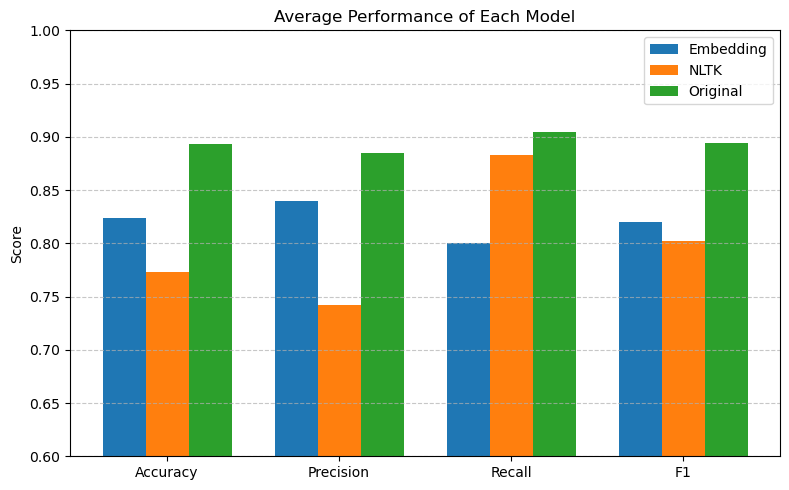

In [63]:
import matplotlib.pyplot as plt



# Set up plot
metrics = ["Accuracy", "Precision", "Recall", "F1"]
x = range(len(metrics))

plt.figure(figsize=(8, 5))

# Plot bars for each model
for i, model in enumerate(avg_scores["Model"]):
    plt.bar([p + i*0.25 for p in x], avg_scores.loc[i, metrics], width=0.25, label=model)

# Format x-axis
plt.xticks([p + 0.25 for p in x], metrics)
plt.ylabel("Score")
plt.ylim(0.6, 1.0)
plt.title("Average Performance of Each Model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


This bar chart compares the average performance of the Original, NLTK, and Embedding based models across four evaluation metrics. The Original model clearly outperforms the others, showing the highest scores in all metrics. While the Embedding model performs slightly better than the NLTK version in accuracy and precision, it falls behind in recall. The NLTK based model shows the lowest precision overall. These results suggest that the Bag of Words model with minimal preprocessing and well chosen weights is the most effective for this sentiment classification task.